In [1]:
import passion

import csv
import pathlib
import matplotlib.pyplot as plt
import shapely.wkt
import PIL
from PIL import ImageFont

2022-06-27 16:52:13.572124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/internal/home/r-pueblas/.conda/envs/passion/lib/python3.8/site-packages/cv2/../../lib64::/opt/ohpc/pub/apps/gurobi/linux64/lib:/opt/ohpc/pub/apps/gurobi/linux64/lib
2022-06-27 16:52:13.572185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


2022-06-27 16:52:15.492914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/internal/home/r-pueblas/.conda/envs/passion/lib/python3.8/site-packages/cv2/../../lib64::/opt/ohpc/pub/apps/gurobi/linux64/lib:/opt/ohpc/pub/apps/gurobi/linux64/lib
2022-06-27 16:52:15.492973: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 16:52:15.493002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iek3028.iek.kfa-juelich.de): /proc/driver/nvidia/version does not exist
2022-06-27 16:52:15.493317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 

In [2]:
results_path = pathlib.Path('/storage/internal/home/r-pueblas/passion/workflow/output/')

satellite_results_path = results_path / 'satellite'
technical_results_path = results_path / 'technical'
economic_results_path = results_path / 'economic'

sections = passion.util.io.load_csv(economic_results_path, 'lcoe.csv')

In [3]:
for section in sections:
    section['outline_latlon'] = list(shapely.wkt.loads(section['outline_latlon']).exterior.coords)
    section['outline_xy'] = list(shapely.wkt.loads(section['outline_xy']).exterior.coords)

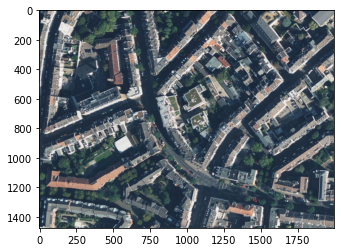

In [4]:
img_path = satellite_results_path
img_name = '50D46M24616SNORTH_06D04M36506SEAST_19L'
image = passion.util.io.load_image(img_path / (img_name + '.png'))

plt.imshow(image)

In [5]:
img_latlon, img_zoom = passion.util.gis.extract_filename(img_name)
img_bbox = passion.util.gis.get_image_bbox(img_latlon, img_zoom, image.shape[:2])

In [6]:
img_sections = []
for section in sections:
    if section['original_image_name'] == (img_name + '.png'):
        img_sections.append(section)

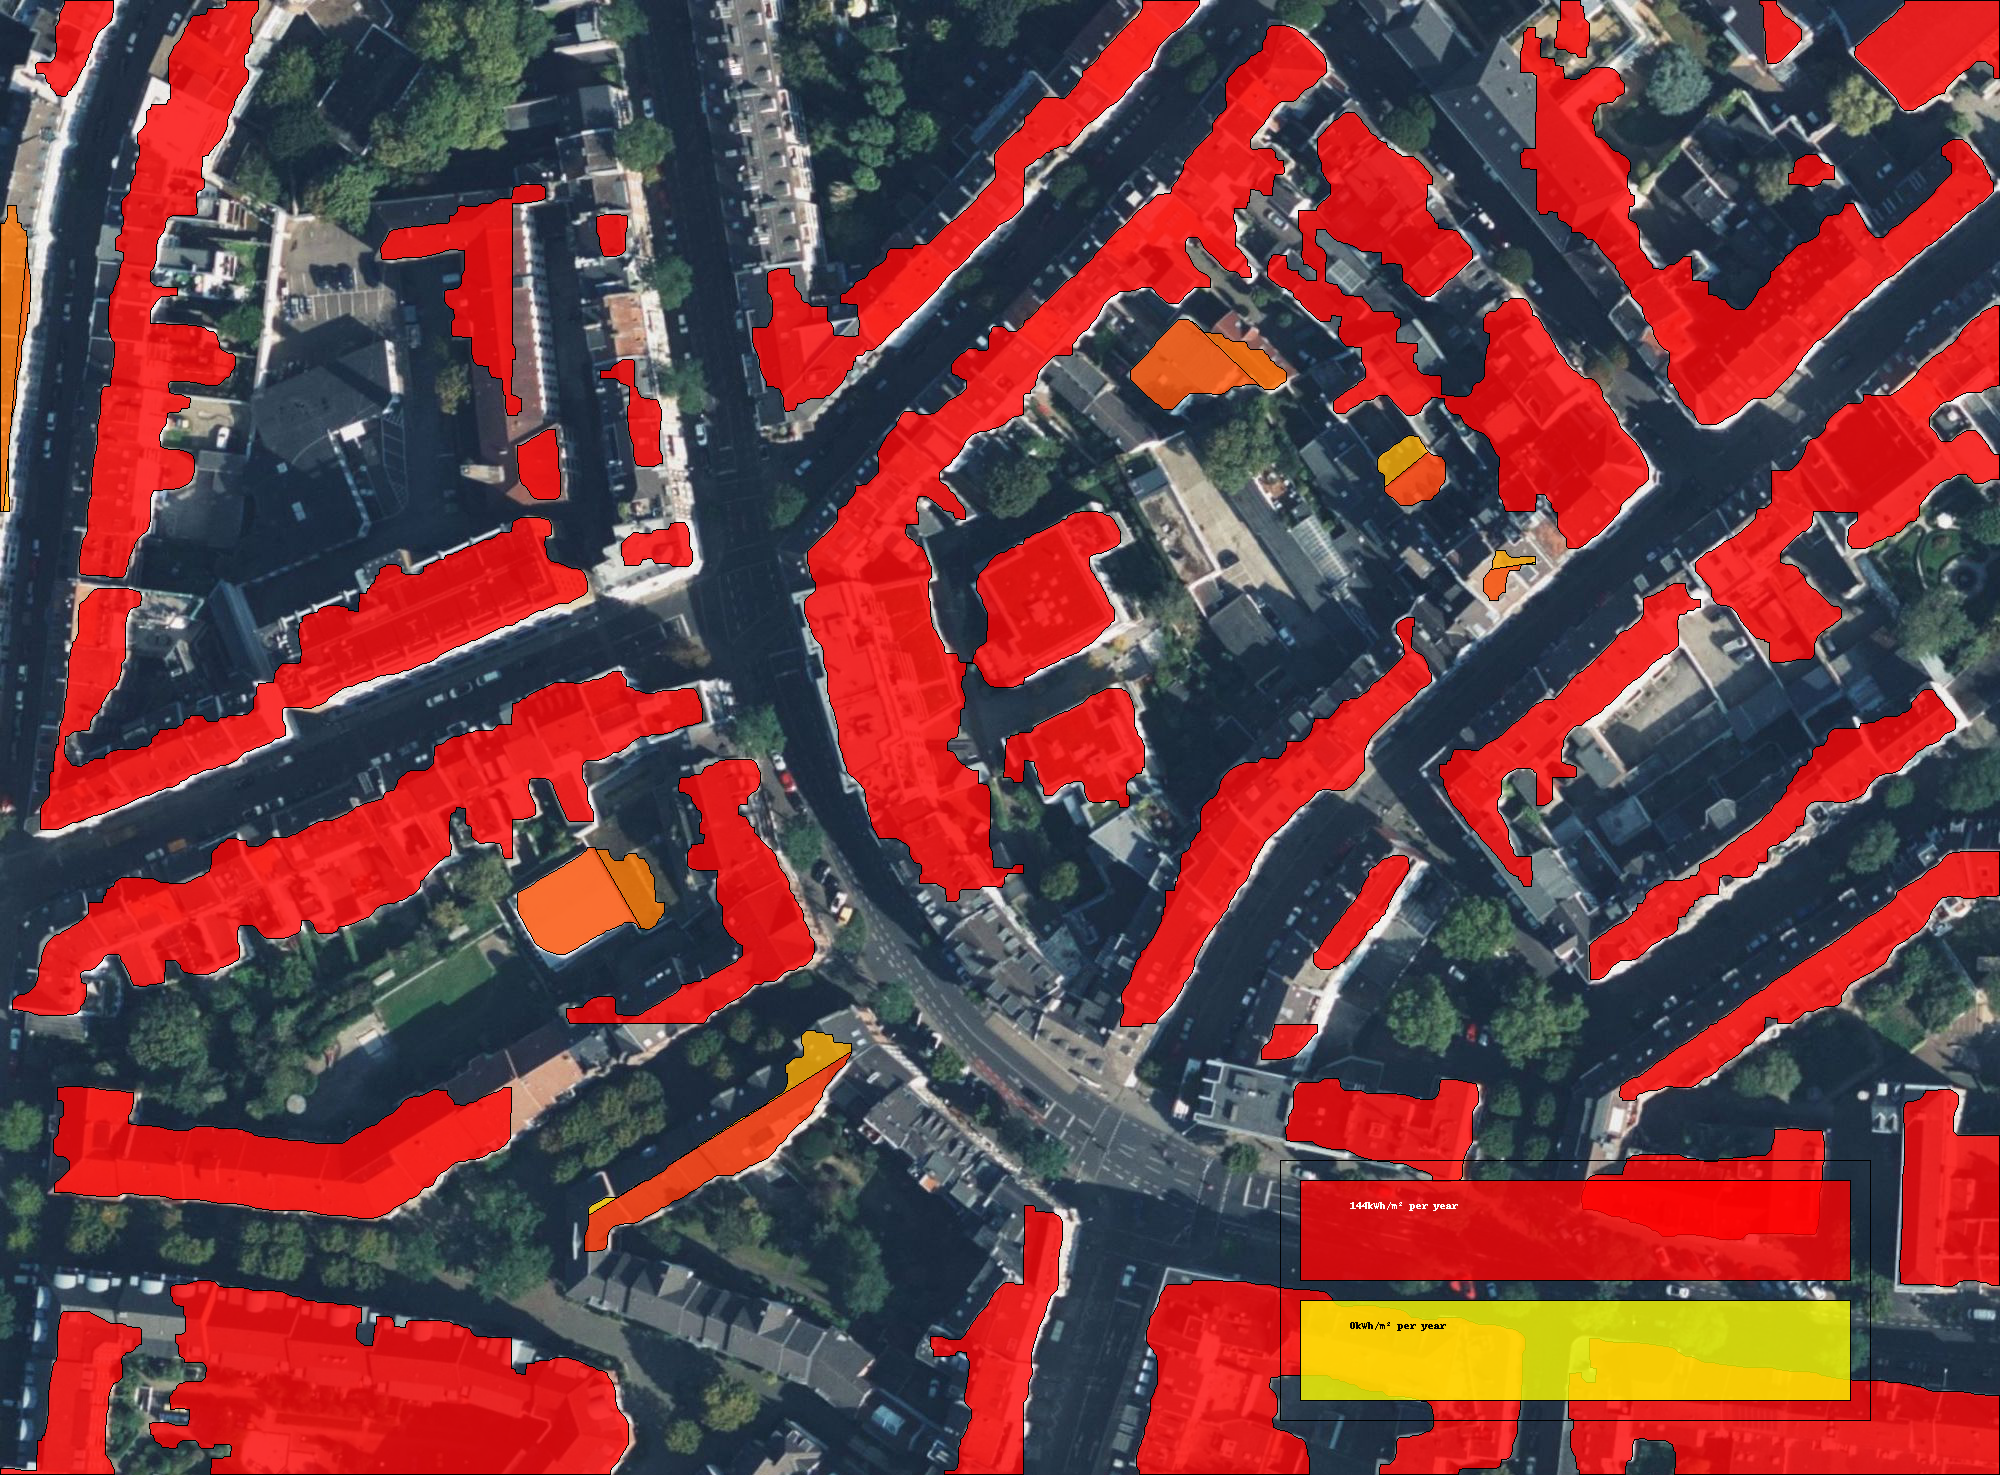

In [55]:
im_copy = PIL.Image.fromarray(image)

draw = PIL.ImageDraw.Draw(im_copy, 'RGBA')

max_gen = 0
max_prop = 0
for d in img_sections:
    max_gen = max(max_gen, d['yearly_gen'])
    max_prop = max(max_prop, d['yearly_gen'] / d['area'])
    
for section in img_sections:
    if not section['flat']:
        gen = section['yearly_gen']
        area = section['area']
        prop = gen / area

        gen_norm = gen / max_gen
        prop_norm = prop / max_prop

        intensity = int(prop_norm * 255)
        draw.polygon(list(section['outline_xy']), fill=(255, 300-intensity, 0, 200), outline=(0,0,0))
    if section['flat']:
        draw.polygon(list(section['outline_xy']), fill=(255, 0, 0, 200), outline=(0,0,0))

legend = [(1300,1180),(1850,1180),(1850,1280),(1300,1280)]
draw.polygon(legend, fill=(255,0,0,200), outline=(0,0,0))
legend = [(1300,1300),(1850,1300),(1850,1400),(1300,1400)]
draw.polygon(legend, fill=(255,255,0,200), outline=(0,0,0))
legend = [(1280, 1160), (1870, 1160), (1870, 1420), (1280, 1420)]
draw.polygon(legend, fill=(0,0,0,0), outline=(0,0,0))
font = ImageFont.load_default()
draw.text((1350,1200), str(int(max_prop/1000)) + 'kWh/m² per year', font=font, fill=(255,255,255,128))
draw.text((1350,1320), '0kWh/m² per year', font=font, fill=(0,0,0,128))

im_copy

In [61]:
total_gen = 0
total_area = 0

for section in sections:
    total_gen += section['yearly_gen']
    total_area += section['area']

print("Total generation: ", total_gen // 1000000000, "GWh")
print("Total area: ", int(total_area), "m^2")
print("Total sections: ", len(sections))
print("Average area: ", total_area // len(sections), "m^2")

Total generation:  28.0 GWh
Total area:  201476 m^2
Total sections:  416
Average area:  484.0 m^2
